A simple 2-node simulation demonstration the application of GP-CaKe. Of particular interest are the covariance parameters
that define the constraints on the posterior shape of the causal kernels.

References:
    Ambrogioni, L., Hinne, M., van Gerven, M., & Maris, E. (2017). GP CaKe: Effective brain connectivity with causal kernels,
    pp. 1–10. Retrieved from http://arxiv.org/abs/1705.05603

Last updated on July 6th, 2017.

In [1]:
%matplotlib inline
import numpy as np

"""
Simulation and GP-CaKe packages.
"""

import gp_cake.simulator as sim
from gp_cake import gpcake 
from gp_cake import utility
from gp_cake import diagnostics 

gp_cake/diagnostics.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/vol/optdcc/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/vol/opt

Construction of simulated time series data. Here, we start with a 2-node graph with one connection (with max. strength <connection_strength>).

We create a 4 second time series per node, with a sampling rate of 100 Hz. <ntrials_train> trials are then generated to train the dynamic parameters on, and <ntrials_test> to learn the GP posterior.

In [2]:
p                       = 2
adj_mat                 = np.zeros((p,p))
adj_mat[0,1]            = 1
connection_strength     = 1.0
time_step               = 0.01
time_period             = 4.
time_range              = np.arange(-time_period / 2, time_period / 2, time_step)
ntime_points            = int(time_period / time_step)
simulation_params       = {'network'                : adj_mat,
                           'connection_strength'    : connection_strength,
                           'time_step'              : time_step,
                           'time_period'            : time_period}

ntrials_train                                       = 200
ntrials_test                                        = 200
simulation                                          = sim.integroDifferential_simulator()

(training_samples, testing_samples, ground_truth)   = simulation.simulate_network_dynamics(ntrials_train, 
                                                                                           ntrials_test, 
                                                                                           simulation_params)

Plot a few samples to see the generated time series.

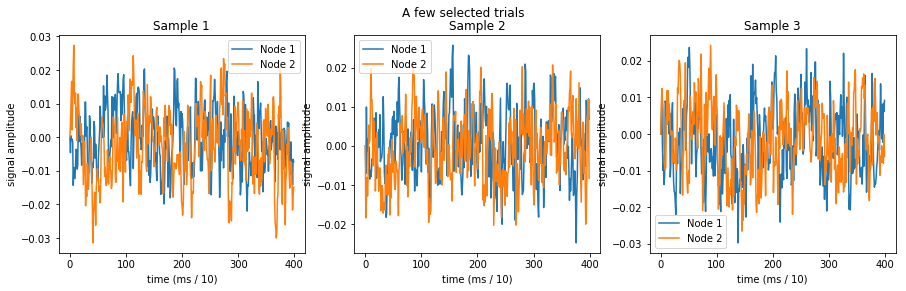

In [3]:
diagnostics.plot_samples(training_samples[0:3])

In [4]:
training_samples[1].shape

(2, 400)

Simulation is done. Time to bake some cake!

Set up the GP CaKe object and initialize. Currently implemented types of dynamics are 'Relaxation' and 'Oscillation'.

In [4]:
cake = gpcake.gpcake()
cake.initialize_time_parameters(time_step, time_period, ntime_points)
cake.dynamic_parameters["number_sources"] = p
cake.dynamic_type = "Relaxation"

Optimize the univariate likelihoods for each node for the dynamic parameters using a grid search.

In [5]:
dynamic_parameters_range = {}
dynamic_parameters_range["relaxation_constant"] = {}
dynamic_parameters_range["relaxation_constant"]["step"] = 2
dynamic_parameters_range["relaxation_constant"]["min"] = 20
dynamic_parameters_range["relaxation_constant"]["max"] = 50
dynamic_parameters_range["amplitude"] = {}
dynamic_parameters_range["amplitude"]["step"] = 0.001
dynamic_parameters_range["amplitude"]["min"] = 0.005
dynamic_parameters_range["amplitude"]["max"] = 0.015

cake.learn_dynamic_parameters(training_samples, dynamic_parameters_range)

Set the parameters of the causal kernel.

In [6]:
cake.set_covariance_parameters(time_scale = 0.2,     
                               time_shift = 0.1,      
                               spectral_smoothing = np.pi,
                               number_sources = p,
                               noise_level = 0.05)

Compute the posteriors for each of the p*(p-1) connections.

In [7]:
cake.parallelthreads=1
connectivity = cake.run_analysis(testing_samples)

Visualize the posterior kernels.

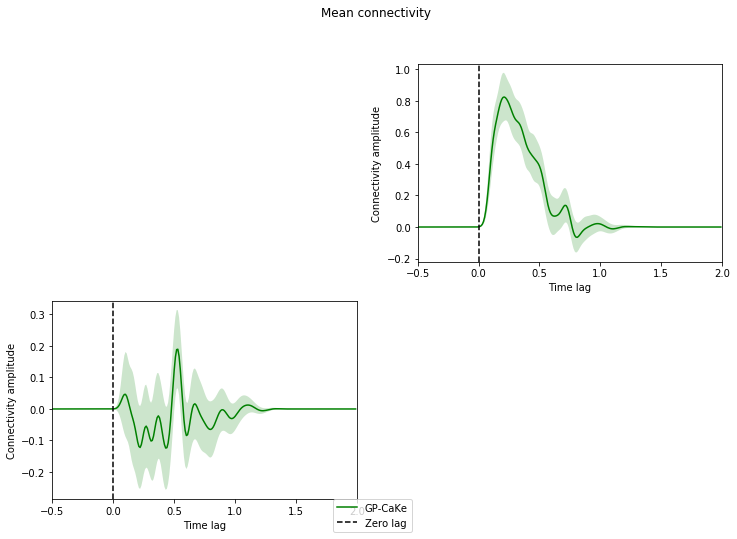

In [8]:
diagnostics.plot_connectivity(ground_truth, connectivity, time_range, t0=-0.5)